In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def to_binary(num1, num2):
    
    num1_b = bin(num1)[2:]
    num2_b = bin(num2)[2:]
    sum_b  = bin(num1+num2)[2:]
    
    l1, l2, ls = len(num1_b), len(num2_b), len(sum_b)
    
    num1_b = '0'*(ls-l1) + num1_b
    num2_b = '0'*(ls-l2) + num2_b
        
    return num1_b, num2_b, sum_b

In [3]:
def bernoulli_noise(true_image, p):
    
    assert len(true_image.shape) == 2
    assert 0 <= p <= 1
    
    if p == 0:
        res_img = true_image
    if p == 1:
        res_img = 1 - true_image
    else:
        noise_matrix = np.zeros(true_image.shape, np.uint8)

        for i in range(true_image.shape[0]):
            for j in range(true_image.shape[1]):

                if np.random.rand() <= p:
                    noise_matrix[i, j] = 1

        res_img = true_image ^ noise_matrix
        
    plt.imshow(res_img)
    return res_img

In [4]:
def render(num_b, one_ref, zero_ref):

    char_h, char_w = one_ref.shape
    
    res = np.zeros( (char_h, char_w*len(num_b)), dtype=np.uint8 )
    
    for i in range(len(num_b)):
        
        if num_b[i] == '1':
            res[:, i*char_w :(i+1)*char_w] = one
        if num_b[i] == '0':
            res[:, i*char_w :(i+1)*char_w] = zero
    
    return res

In [5]:
bin(123)[2:]

'1111011'

In [6]:
def render_img(n1, n2, one_ref, zero_ref, _sum=None):
    
    char_h, char_w = one_ref.shape
    
    # decimal to binary
    if _sum == None:
        n1_b, n2_b, _sum = to_binary(n1, n2)
    else:
        n1_b, n2_b, _ = to_binary(n1, n2)
        _sum = bin(_sum)[2:]
    
    # render binary to img
    n1_img_clean = render(n1_b, one, zero)
    n2_img_clean = render(n2_b, one, zero)
    sum_img      = render(_sum, one, zero)
    
    # concatenate
    res_img = np.zeros( (char_h*3+1, char_w*len(n1_b)), dtype=np.uint8 )
    
    res_img[0:char_h, :] = n1_img_clean
    res_img[char_h:char_h*2, :] = n2_img_clean
    res_img[char_h*2, :] = 1
    res_img[char_h*2+1:char_h*3+1, :] = sum_img
    
    plt.imshow(res_img)
    
    return res_img, len(_sum)
    

In [7]:
def render_res(res, terminals):
    
    n = res.shape[0]
    char_h, char_w = terminals[0].shape
    
    res_img = np.zeros( (char_h, char_w*n), dtype=np.uint8)
    
    for i in range(n):
        res_img[:, char_w*i:char_w*(i+1)] = terminals[res[i]]
        
    return res_img

In [8]:
def generate_terminals(one, zero):
    
    char_h, char_w = one.shape
    terminals = np.zeros( (9, char_h*3+1, char_w), dtype=np.uint8 )
    
    def render_column(b1, b2, s):
        column = np.zeros( (char_h*3+1, char_w), dtype=np.uint8 )
        column[ 0          : char_h     ,:] = b1
        column[ char_h     : char_h*2   ,:] = b2
        column[ char_h*2   : char_h*2+1 ,:] = 1
        column[ char_h*2+1 : char_h*3+1 ,:] = s
        return column
        
    # C_k
    terminals[1 ,:,:] = render_column(zero, zero, zero)
    terminals[2 ,:,:] = render_column(zero, zero, one)
    terminals[3 ,:,:] = render_column(zero, one, zero)
    terminals[4 ,:,:] = render_column(one, zero, zero)
    terminals[5 ,:,:] = render_column(one, one, zero)
    terminals[6 ,:,:] = render_column(one, zero, one)
    terminals[7 ,:,:] = render_column(zero, one, one)
    terminals[8 ,:,:] = render_column(one, one, one)
    
    foo = np.concatenate((terminals[1 ,:,:], terminals[2 ,:,:], terminals[3 ,:,:], terminals[4 ,:,:], terminals[5 ,:,:], terminals[6 ,:,:], terminals[7 ,:,:], terminals[8 ,:,:]), axis=1)
    plt.imshow(foo)
    
    return terminals

In [9]:
def calculate_ref_penalty(terminals, noised_img):
    char_h, char_w = one.shape
    n = int( noised_img.shape[1] / char_w )
    
    penalties = np.full( (n,8), -1 )
    
    for i in range(n):
        for c in range(8):
            
            col = noised_img[:, char_w*i:char_w*(i+1)]
            
            diff = np.abs( col.astype(np.int8) - terminals[c+1,:,:] )
            
            penalties[i,c] = np.sum(diff)
            
    return penalties

In [10]:
def F_init(F, D, g):
    n = F.shape[0]
    
    for i in range(n):
        F, D = f(i, 0, F, D)
        F, D = f(i, 1, F, D)
    
    return F,D

def f(i, u, F, D):
    G1 = [1,6,7]
    G2 = [3,4,8]
    
    if i == 0:
        
        # f(1,us)
        score = np.inf
        best_d = None
        for c in G1:
            foo = g[0][c-1]
            if foo < score:
                score = foo
                best_d = c-1
        F[i, 0] = score
        D[i, 0] = best_d+1
        
        # f(1,us')
        F[i, 1] = g[0][5-1]
        D[i, 1] = 5
        
    else:
        
        # f(i, us)
        score = np.inf
        best_d = None
        for c in G1:
            foo = g[i][c-1] + F[i-1, 0]
            if foo < score:
                score = foo
                best_d = c-1
        
        if score <= g[i][2-1] + F[i-1,1]:
            F[i, 0] = score
            D[i, 0] = best_d+1
        else:
            F[i, 0] = g[i][2-1] + F[i-1,1]
            D[i, 0] = 2           
        
        
        # f(i, us')
        score = np.inf
        best_d = None
        for c in G2:
            foo = g[i][c-1] + F[i-1, 1]
            if foo < score:
                score = foo
                best_d = c-1
        
        if score <= g[i][5-1] + F[i-1,0]:
            F[i, 1] = score
            D[i, 1] = best_d+1
        else:
            F[i, 1] = g[i][5-1] + F[i-1,0]
            D[i, 1] = 5          
        
    return F, D

In [11]:
def restore(D):
    
    n = D.shape[0]
    res = np.full(n, -1, dtype=np.uint8)
    
    def foo(k):
        G0 = [1,5,6,7]
        G1 = [2,3,4,8]
        
        if k in G0:
            return 0
        if k in G1:
            return 1
        
    res[n-1] = D[n-1, 0]
    for i in range(n-1)[::-1]:
        s = foo(res[i+1])
        res[i] = D[i, s]
        
    return res

In [12]:
def check_answer(res_img, inpt_img):
    
    diff = np.abs( res_img.astype(np.int8) - inpt_img )
    sum_ = np.sum(diff)
    
    if sum_ == 0:
        print(f"The answer is correct! :)")
        plt.imshow(res_img)
    else:
        print("The answer is wrong :(")
        print(f"There are {sum_} wrong pixels:")
        plt.imshow(diff)
        
    

In [13]:
one = np.array([
    [0,0,0,0,0],
    [0,0,1,0,0],
    [0,1,1,0,0],
    [0,0,1,0,0],
    [0,0,1,0,0],
    [0,0,1,0,0],
    [0,1,1,1,0],
    [0,0,0,0,0],
])

zero = np.array([
    [0,0,0,0,0],
    [0,1,1,1,0],
    [0,1,0,1,0],
    [0,1,0,1,0],
    [0,1,0,1,0],
    [0,1,0,1,0],
    [0,1,1,1,0],
    [0,0,0,0,0],
])

---

## Main

In [26]:
n1, n2, _sum = 4, 10, 11 
p = 0.3

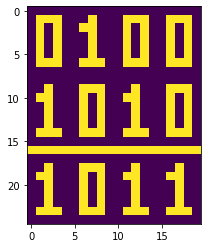

In [29]:
# Input img
inpt_img, n = render_img(n1, n2, one, zero, _sum)

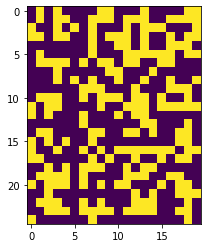

In [30]:
# Noised img
noised_img = bernoulli_noise(inpt_img, p)

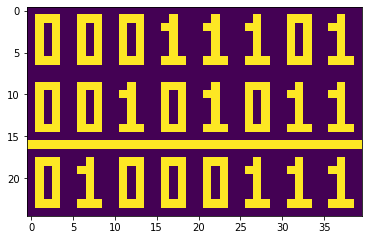

In [31]:
# C_k imgs
terminals = generate_terminals(one, zero)   
#c1  c2   c3   c4   c5   c6   c7   c8

In [32]:
g = calculate_ref_penalty(terminals, noised_img)
g = np.flip(g, axis=0)

In [33]:
F = np.zeros((n, 2))
D = np.zeros((n, 2), dtype=np.uint8)

F, D = F_init(F,D, g)

In [34]:
res = restore(D)[::-1]
res

array([7, 6, 7, 1], dtype=uint8)

---

## Results

original ideal input: 4 + 10 = 11


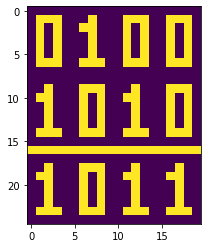

In [43]:
# Ideal input
print(f"original ideal input: {n1} + {n2} = {_sum}")
plt.imshow(inpt_img)

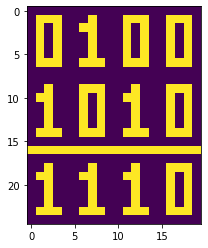

In [44]:
# Result
res_img = render_res(res, terminals)
plt.imshow(res_img)

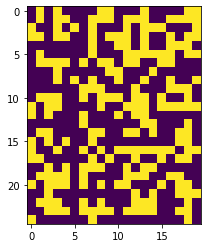

In [37]:
# Actual input
plt.imshow(noised_img)